In [7]:
# !pip install missingno

  Using cached missingno-0.4.2-py3-none-any.whl (9.7 kB)


In [9]:
# !pip install xgboost

In [16]:
# !pip install scikit-optimize

  Using cached scikit_optimize-0.8.1-py2.py3-none-any.whl (101 kB)


In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from xgboost import XGBClassifier
from functools import partial
from skopt import gp_minimize
from skopt import space
from skopt.plots import plot_convergence

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [19]:
df_train = pd.read_csv('../data5/aug_train.csv')
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [20]:
df_test = pd.read_csv('../data5/aug_test.csv')
df_test

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


### 인코딩 

In [25]:
# train 데이터셋과 test 데이터셋을 합치기 위해 test 데이터셋에 임의의 값 부여

df_test['target'] = -1

df_pre = pd.concat([df_train, df_test])
df_pre.reset_index(drop = True)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15,-1.0
21283,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30,-1.0
21284,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18,-1.0
21285,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84,-1.0


In [32]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(2), int64(2), object(10)
mem

In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
df_lb = df_pre.copy()
df_lb['education_level'].value_counts()

Graduate          12867
Masters            4857
High School        2239
Phd                 468
Primary School      344
Name: education_level, dtype: int64

### nan값 채우기

In [35]:
df_lb.loc[:, "education_level"] = df_lb['education_level'].fillna("NONE")

### 인코더로 카테고리화 하기

In [36]:
lbl_enc = LabelEncoder()

df_lb.loc[:, "education_level"] = lbl_enc.fit_transform(df_lb['education_level'].values)
df_lb['education_level'].value_counts()

0    12867
2     4857
1     2239
3      512
4      468
5      344
Name: education_level, dtype: int64

### 타입이 문자열인 경우 

In [37]:
gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':    0
}

enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':    1, 
    'Part time course':    2 
}
    
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
    
experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
    
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

In [40]:
df_pre.loc[:,'education_level'] = df_pre['education_level'].map(education_level_map)
df_pre.loc[:,'company_size'] = df_pre['company_size'].map(company_size_map)
df_pre.loc[:,'company_type'] = df_pre['company_type'].map(company_type_map)
df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(last_new_job_map)
df_pre.loc[:,'major_discipline'] = df_pre['major_discipline'].map(major_map)
df_pre.loc[:,'enrolled_university'] = df_pre['enrolled_university'].map(enrolled_university_map)
df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(relevent_experience_map)
df_pre.loc[:,'gender'] = df_pre['gender'].map(gender_map)
df_pre.loc[:,'experience'] = df_pre['experience'].map(experience_map)

In [41]:
df_pre.loc[:,'city'] = lbl_enc.fit_transform(df_pre.loc[:,'city']) 

In [42]:
df_pre.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


In [43]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21287 entries, 0 to 2128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  int64  
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  float64
 4   relevent_experience     21287 non-null  int64  
 5   enrolled_university     20870 non-null  float64
 6   education_level         20775 non-null  float64
 7   major_discipline        18162 non-null  float64
 8   experience              21217 non-null  float64
 9   company_size            14727 non-null  float64
 10  company_type            14513 non-null  float64
 11  last_new_job            20824 non-null  float64
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(10), int64(4)
memory usage: 

### 결측치 시각화

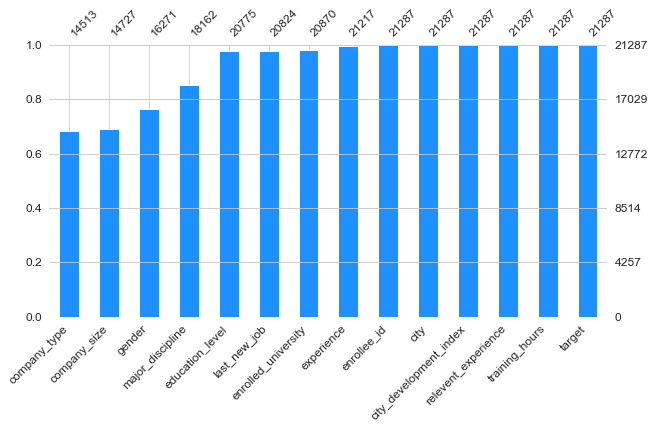

In [45]:
missingno.bar(df_pre,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

In [46]:
for col in df_pre.columns:
    null_val = df_pre[col].isnull().sum()
    null_prec = (null_val * 100) / df_pre.shape[0]
    print('> %s , Missing: %d (%.1f%%)' % (col, null_val, null_prec))

> enrollee_id , Missing: 0 (0.0%)
> city , Missing: 0 (0.0%)
> city_development_index , Missing: 0 (0.0%)
> gender , Missing: 5016 (23.6%)
> relevent_experience , Missing: 0 (0.0%)
> enrolled_university , Missing: 417 (2.0%)
> education_level , Missing: 512 (2.4%)
> major_discipline , Missing: 3125 (14.7%)
> experience , Missing: 70 (0.3%)
> company_size , Missing: 6560 (30.8%)
> company_type , Missing: 6774 (31.8%)
> last_new_job , Missing: 463 (2.2%)
> training_hours , Missing: 0 (0.0%)
> target , Missing: 0 (0.0%)


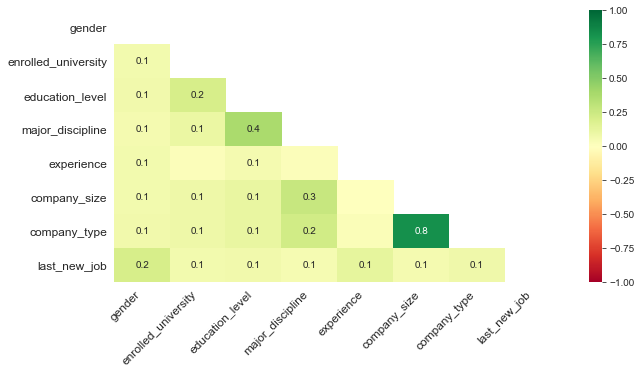

In [47]:
missingno.heatmap(df_pre, cmap="RdYlGn", figsize=(10,5), fontsize=12);

### 결측치를 처리하기 위한 KNNImputer

In [48]:
df_pre1 = df_pre.copy()

In [49]:
knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_pre1))
df_pre1 = pd.DataFrame(X, columns = df_pre1.columns)

In [50]:
df_pre1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  float64
 1   city                    21287 non-null  float64
 2   city_development_index  21287 non-null  float64
 3   gender                  21287 non-null  float64
 4   relevent_experience     21287 non-null  float64
 5   enrolled_university     21287 non-null  float64
 6   education_level         21287 non-null  float64
 7   major_discipline        21287 non-null  float64
 8   experience              21287 non-null  float64
 9   company_size            21287 non-null  float64
 10  company_type            21287 non-null  float64
 11  last_new_job            21287 non-null  float64
 12  training_hours          21287 non-null  float64
 13  target                  21287 non-null  float64
dtypes: float64(14)
memory usage: 2.3 MB


### 커널 밀도 추정(KDE: Kernel Density Estimator)

평균과 신뢰구간이 비슷한 경우, 어떤 데이터인지 구분이 안 된다. 최대값, 최소값은 어떤지, 어떤 모양으로 얼마나 퍼져 있는지 분포가 확인이 안 되는 거다.

그래서 보통 분포를 확인할 때 히스토그램(histogram)을 많이 활용하곤 한다. 구간을 나눠서 막대 그래프를 그리는 거다. 그런데 히스토그램은 구간을 어떻게 설정하냐에 따라 결과물이 매우 달라져서, 엉뚱한 결론과 해석을 내릴 수 있기 때문에 조심해야 한다.

그래서 그 대안으로 많이 쓰이는 게 커널 밀도 추정(KDE: Kernel Density Estimator)

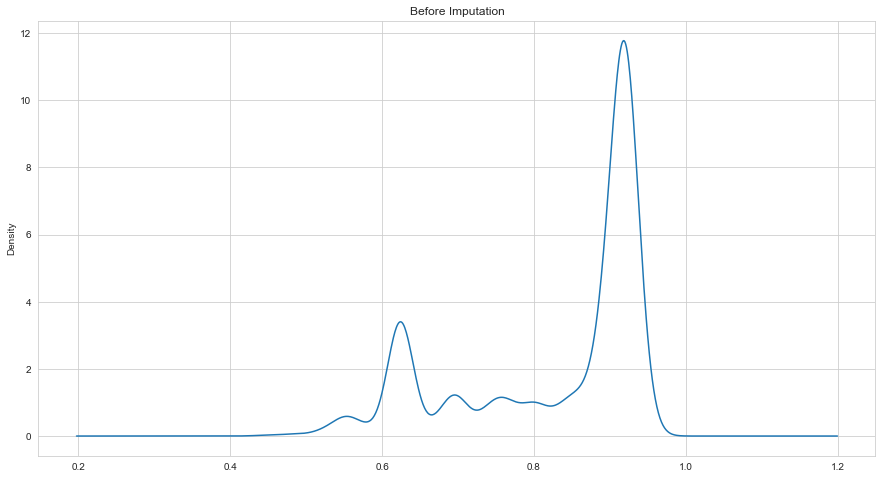

In [51]:
plt.figure(figsize = (15,8))
plt.title('Before Imputation')
df_pre['city_development_index'].plot(kind = 'kde')
plt.show()

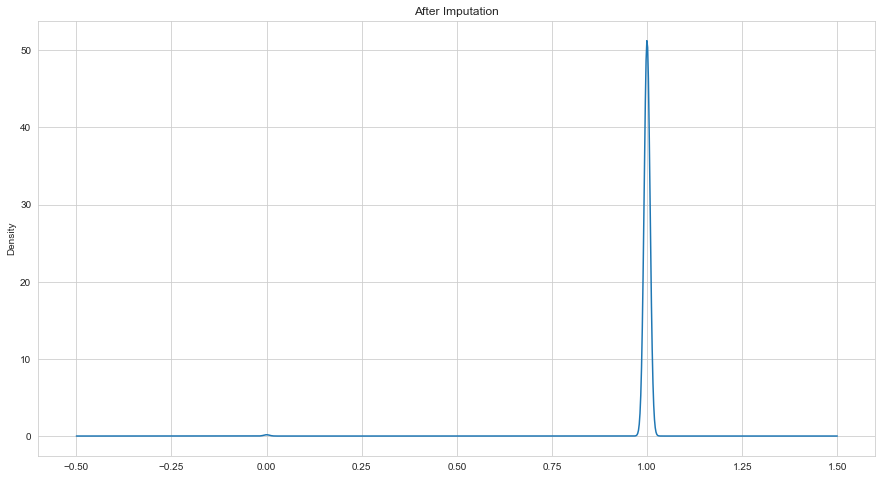

In [52]:
plt.figure(figsize = (15,8))
plt.title('After Imputation')
df_pre1['city_development_index'].plot(kind = 'kde')
plt.show()

In [53]:
missing_cols = df_pre.columns[df_pre.isna().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [55]:
# df_non_missing 은 식별하기 위해 추가적으로 넣어줌 -> 나중에 merge하기 위해

df_missing = df_pre[['df_non_missing'] + missing_cols]

In [56]:
df_missing

,enrollee_id,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,8949,1.0,0.0,2.0,0.0,21.0,NaN,NaN,1.0
1,29725,1.0,0.0,2.0,0.0,15.0,5.0,0.0,5.0
2,11561,NaN,1.0,2.0,0.0,5.0,NaN,NaN,0.0
3,33241,NaN,NaN,2.0,1.0,0.0,NaN,0.0,0.0
4,666,1.0,0.0,3.0,0.0,21.0,5.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...
2124,1289,1.0,0.0,2.0,3.0,16.0,NaN,4.0,4.0
2125,195,1.0,0.0,3.0,0.0,18.0,NaN,NaN,2.0
2126,31762,1.0,0.0,0.0,NaN,3.0,NaN,0.0,0.0
2127,7873,1.0,1.0,1.0,NaN,7.0,2.0,4.0,1.0


In [57]:
df_non_missing = df_pre.drop(missing_cols, axis = 1)

In [58]:
df_non_missing

,enrollee_id,city,city_development_index,relevent_experience,training_hours,target
0,8949,5,0.920,1,36,1.0
1,29725,77,0.776,0,47,0.0
2,11561,64,0.624,0,83,0.0
3,33241,14,0.789,0,52,1.0
4,666,50,0.767,1,8,0.0
...,...,...,...,...,...,...
2124,1289,5,0.920,0,15,-1.0
2125,195,30,0.897,1,30,-1.0
2126,31762,2,0.887,0,18,-1.0
2127,7873,4,0.804,1,84,-1.0


### k-Nearest Neighbour Imputation

In [59]:
knn_imputer = KNNImputer(n_neighbors = 3)
X = np.round(knn_imputer.fit_transform(df_missing))
df_missing = pd.DataFrame(X, columns = df_missing.columns)

In [60]:
df_pre2 = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')

In [61]:
train = df_pre2[df_pre2['target'] != -1].reset_index(drop = True)
test = df_pre2[df_pre2['target'] == -1].reset_index(drop = True)

X = train.drop(['enrollee_id', 'target'], axis = 1)
Y = train['target']

In [62]:
test = test.drop('target', axis = 1)

### 모델 학습

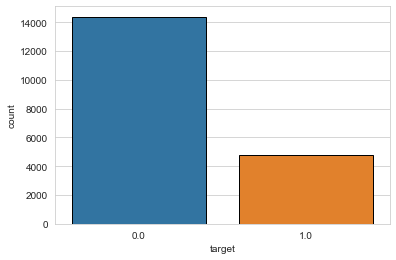

In [64]:
# label이 0과 1 => imbalanced data

sns.countplot(train['target'], edgecolor = 'black')
plt.show()

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
# 학습 데이터를 train 데이터셋과 validation 데이터셋으로 나눔 8:2

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2 ,random_state = 42)

#### XGBoost

In [67]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

[17:02:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
y_train_pred = clf.predict_proba(X_train)

In [69]:
# 0과 1에 대한 확률값

y_train_pred

array([[0.85712457, 0.14287546],
       [0.9250089 , 0.07499111],
       [0.7289727 , 0.2710273 ],
       ...,
       [0.8348379 , 0.16516212],
       [0.27794957, 0.7220504 ],
       [0.9479542 , 0.05204585]], dtype=float32)

In [70]:
y_train_pred_pos = y_train_pred[:,1]

In [71]:
y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

In [72]:
auc_train = roc_auc_score(y_train, y_train_pred_pos) # train 데이터섯
auc_test = roc_auc_score(y_val, y_val_pred_pos)      # validation 데이터섯

In [74]:
print(f"Train AUC Score : {auc_train}")
print(f"Test AUC Score  : {auc_test}")

Train AUC Score : 0.9234348363001115
Test AUC Score  : 0.7604762998949579


#### ROC 커브 그리기

In [76]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

In [77]:
def plot_auc_curve(fpr, tpr, auc):
    plt.figure(figsize = (16,6))
    plt.plot(fpr,tpr,'b+',linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5)
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Postive Rate')
    plt.title(f'ROC Curve Having AUC = {auc}')

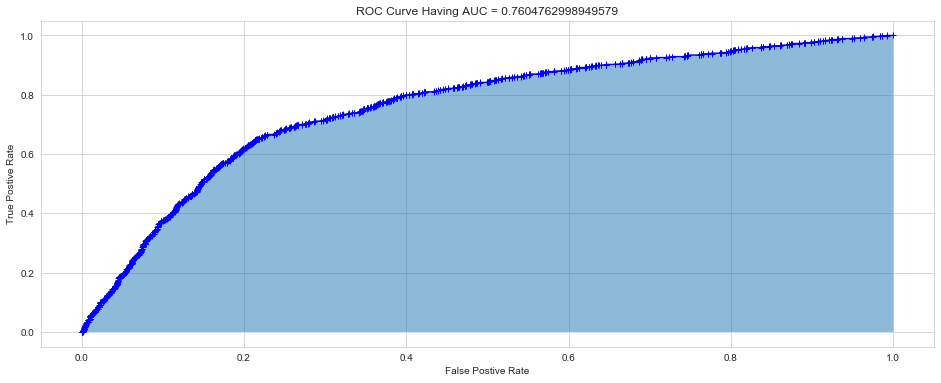

In [78]:
plot_auc_curve(fpr, tpr, auc_test)

#### Learning 커브 그리기

In [79]:
def plot_learning_cuve(model, X, Y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(200,len(x_train),200):
        
        model.fit(x_train.iloc[:m,:], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')



    plt.show()

[17:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:07:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:07:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

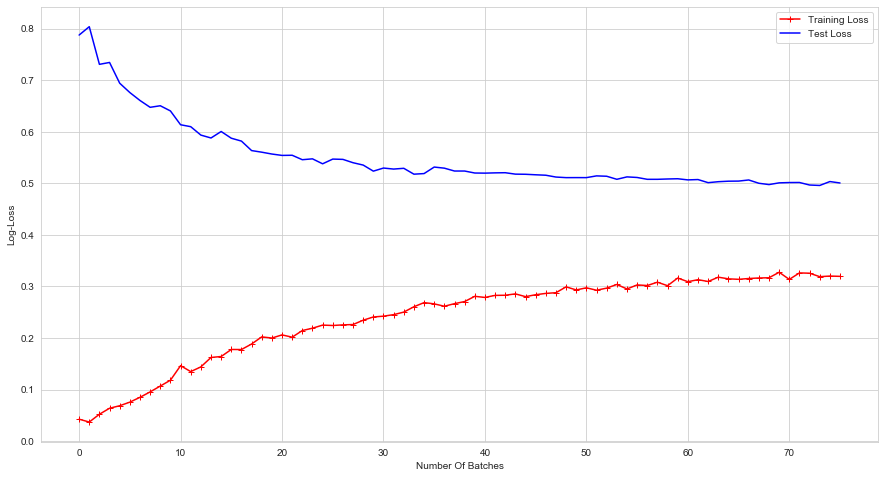

In [80]:
plot_learning_cuve(XGBClassifier(), X, Y)

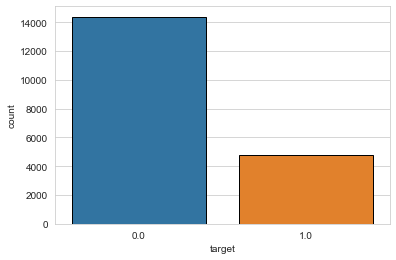

In [81]:
sns.countplot(Y, edgecolor = 'black')
plt.show()

### SMOTE로 OverSampling 

In [82]:
from imblearn.over_sampling import SMOTE

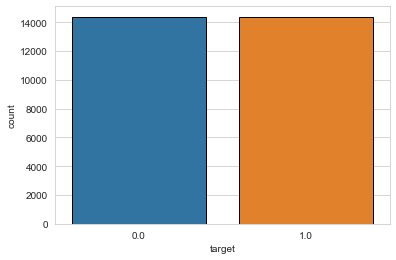

In [85]:
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(X,Y)


sns.countplot(Y_smote, edgecolor = 'black')
plt.show()

In [84]:
print(X_smote.shape)

(28762, 12)


In [87]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

[17:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train AUC Score 0.9702487021123427
Test AUC Score 0.9213068444132473


[17:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:12:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

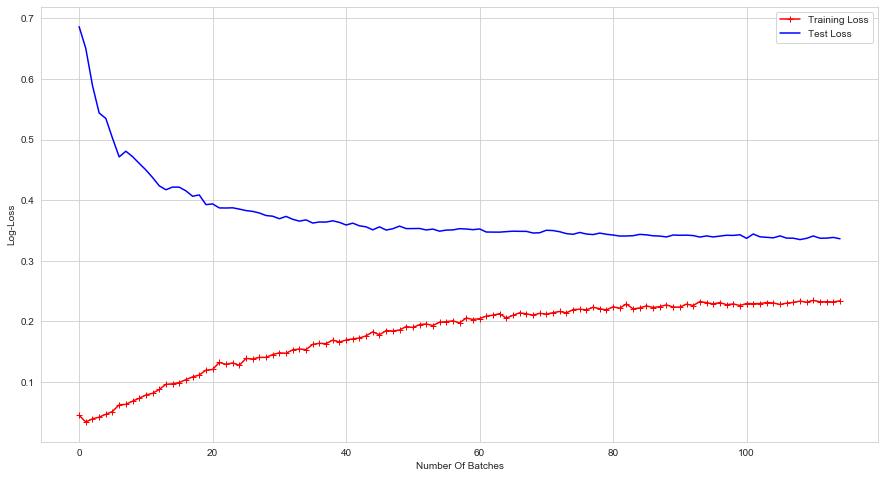

In [88]:
plot_learning_cuve(XGBClassifier(), X_smote, Y_smote)

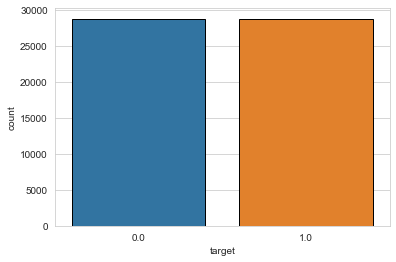

In [90]:
# 한 번더 SMOTE를 함으로써 오버샘플링

smote = SMOTE(random_state = 446)
X_smote1, Y_smote1 = smote.fit_resample(X,Y)


X_final = pd.concat([X_smote, X_smote1], axis = 0).reset_index(drop = True)
Y_final = pd.concat([Y_smote, Y_smote1], axis = 0).reset_index(drop = True)

sns.countplot(Y_final, edgecolor = 'black')
plt.show()

In [91]:
print(X_final.shape)

(57524, 12)


In [92]:
X_train, X_val, y_train, y_val = train_test_split(X_final, Y_final, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()


clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

[17:15:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train AUC Score 0.9679081635553716
Test AUC Score 0.9488718409479533


[17:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:16:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:17:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

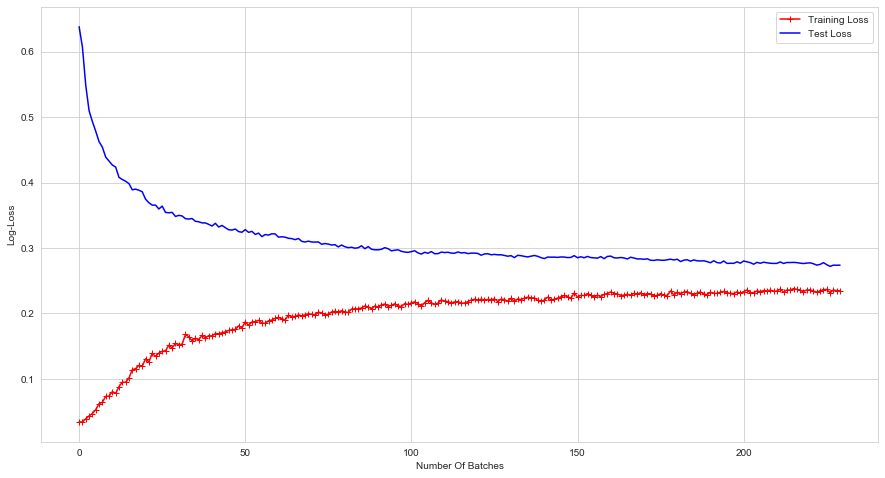

In [93]:
plot_learning_cuve(XGBClassifier(), X_final, Y_final)

### 하이퍼파라미터 튜닝: Bayesian optimization

In [94]:
def optimize(params, param_names, x, y):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    clf = XGBClassifier(tree_method = 'hist', **params)
    
    # initialize stratified k fold
    # StratifiedKFold는 k-fold가 label을 데이터와 학습에 올바르게 분배하지 못하는 경우를 해결
    
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]

    
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)

In [95]:
param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Real(0.01,100, name = 'min_child_weight'),
                space.Real(0.01,1000, name = 'gamma'),
                space.Real(0.1, 1, prior = 'uniform', name = 'colsample_bytree'),
]

param_names = ['n_estimators' ,'min_child_weight', 'gamma', 'colsample_bytree']

optimize_function = partial(optimize, param_names = param_names, x = X_smote, y = Y_smote) # optimize함수 사용!

In [96]:
result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 30, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
[17:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 0 -> {'n_estimators': 1958, 'min_child_weight': 21.674601334841665, 'gamma': 783.8654274003911, 'colsample_bytree': 0.1926466714510589}
AUC score of test 0 f 0.7310287383077043
[17:20:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 1 -> {'n_estimators': 1958, 'min_child_weight': 21.674601334841665, 'gamm

Current parameters of fold number 0 -> {'n_estimators': 1755, 'min_child_weight': 64.87587058200141, 'gamma': 577.8116332090444, 'colsample_bytree': 0.7158292021033219}
AUC score of test 0 f 0.7449864350276013
[17:20:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 1 -> {'n_estimators': 1755, 'min_child_weight': 64.87587058200141, 'gamma': 577.8116332090444, 'colsample_bytree': 0.7158292021033219}
AUC score of test 1 f 0.8197066635147201
[17:20:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if 

Current parameters of fold number 0 -> {'n_estimators': 744, 'min_child_weight': 100.0, 'gamma': 406.08227068592277, 'colsample_bytree': 0.8115650627643769}
AUC score of test 0 f 0.7515043051625694
[17:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 1 -> {'n_estimators': 744, 'min_child_weight': 100.0, 'gamma': 406.08227068592277, 'colsample_bytree': 0.8115650627643769}
AUC score of test 1 f 0.8320298922488704
[17:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore th

Current parameters of fold number 1 -> {'n_estimators': 100, 'min_child_weight': 69.01191162095724, 'gamma': 257.53684081412104, 'colsample_bytree': 0.1}
AUC score of test 1 f 0.8259341146486716
[17:20:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 2 -> {'n_estimators': 100, 'min_child_weight': 69.01191162095724, 'gamma': 257.53684081412104, 'colsample_bytree': 0.1}
AUC score of test 2 f 0.9725941004253706
[17:20:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Current parameters of fold number 2 -> {'n_estimators': 2000, 'min_child_weight': 100.0, 'gamma': 0.01, 'colsample_bytree': 0.1}
AUC score of test 2 f 0.9944651288975378
[17:21:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 3 -> {'n_estimators': 2000, 'min_child_weight': 100.0, 'gamma': 0.01, 'colsample_bytree': 0.1}
AUC score of test 3 f 0.9956357926419982
[17:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 4 -> {

Current parameters of fold number 3 -> {'n_estimators': 2000, 'min_child_weight': 0.01, 'gamma': 0.01, 'colsample_bytree': 1.0}
AUC score of test 3 f 0.9978240017138623
[17:21:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 4 -> {'n_estimators': 2000, 'min_child_weight': 0.01, 'gamma': 0.01, 'colsample_bytree': 1.0}
AUC score of test 4 f 0.9975381967885393
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 21.0670
Function value obtained: -0.9030
Current minimum: -0.9185
Iteration No: 17 started. Searching for the next optimal point.
[17:21:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default e

Current parameters of fold number 3 -> {'n_estimators': 1370, 'min_child_weight': 98.01178248009249, 'gamma': 4.290042113940337, 'colsample_bytree': 0.10142013012216466}
AUC score of test 3 f 0.9893804247322331
[17:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 4 -> {'n_estimators': 1370, 'min_child_weight': 98.01178248009249, 'gamma': 4.290042113940337, 'colsample_bytree': 0.10142013012216466}
AUC score of test 4 f 0.9900687624404936
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 5.2570
Function value obtained: -0.9149
Current minimum: -0.9200
Iteration No: 20 started. Searching for the next optimal point.
[17:21:53] WARNING: C:/Users/Administrator/workspace/xgboos

Current parameters of fold number 3 -> {'n_estimators': 808, 'min_child_weight': 85.41425098283275, 'gamma': 0.13085664787143178, 'colsample_bytree': 0.979388996869107}
AUC score of test 3 f 0.9965412042687939
[17:22:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 4 -> {'n_estimators': 808, 'min_child_weight': 85.41425098283275, 'gamma': 0.13085664787143178, 'colsample_bytree': 0.979388996869107}
AUC score of test 4 f 0.9969086159304086
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 4.5491
Function value obtained: -0.9164
Current minimum: -0.9200
Iteration No: 23 started. Searching for the next optimal point.
[17:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-

Current parameters of fold number 3 -> {'n_estimators': 1997, 'min_child_weight': 37.799593111927635, 'gamma': 5.149236132915036, 'colsample_bytree': 0.9982211979494511}
AUC score of test 3 f 0.9898519907691297
[17:22:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 4 -> {'n_estimators': 1997, 'min_child_weight': 37.799593111927635, 'gamma': 5.149236132915036, 'colsample_bytree': 0.9982211979494511}
AUC score of test 4 f 0.9898521116679981
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.5979
Function value obtained: -0.9177
Current minimum: -0.9200
Iteration No: 26 started. Searching for the next optimal point.
[17:22:28] WARNING: C:/Users/Administrator/workspace/xgboo

Current parameters of fold number 3 -> {'n_estimators': 216, 'min_child_weight': 97.1092360647438, 'gamma': 1.333912667754287, 'colsample_bytree': 0.9610746654616796}
AUC score of test 3 f 0.9932163644839744
[17:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Current parameters of fold number 4 -> {'n_estimators': 216, 'min_child_weight': 97.1092360647438, 'gamma': 1.333912667754287, 'colsample_bytree': 0.9610746654616796}
AUC score of test 4 f 0.994088528921911
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.6587
Function value obtained: -0.9194
Current minimum: -0.9200
Iteration No: 29 started. Searching for the next optimal point.
[17:22:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64

In [97]:
best_params = dict(zip(param_names, result.x))
print(f'Best Parameters : {best_params}')
print(f'Best AUC score : {result.fun}')

Best Parameters : {'n_estimators': 214, 'min_child_weight': 0.2132290585259193, 'gamma': 0.9777532770637053, 'colsample_bytree': 0.11047836466175909}
Best AUC score : -0.920028172317445


In [98]:
# splitting train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 2020)

# initialize model with best parameters
clf = XGBClassifier(**best_params)

# fit model
clf.fit(X_train, y_train)

# predicting probabilities of training data
y_train_pred = clf.predict_proba(X_train)


y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

[17:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train AUC Score 0.9270664056614792
Test AUC Score 0.9252707665908317


[17:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:23:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

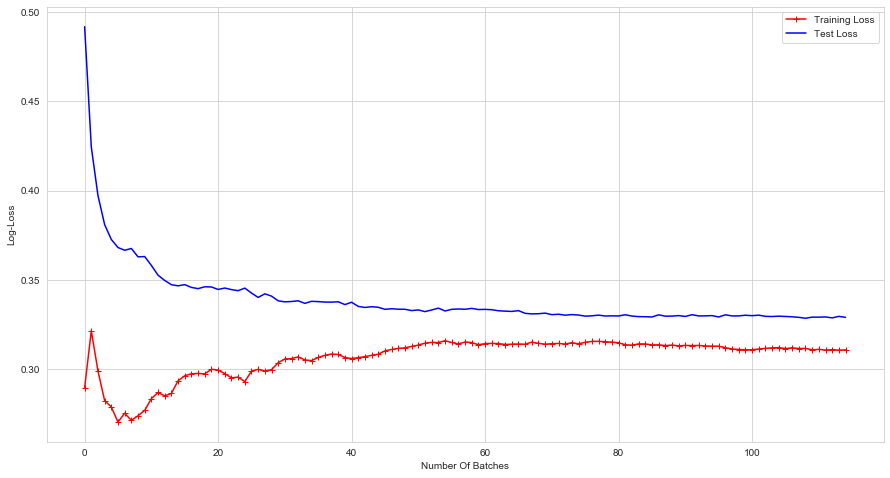

In [99]:
plot_learning_cuve(XGBClassifier(**best_params),X_smote,Y_smote)

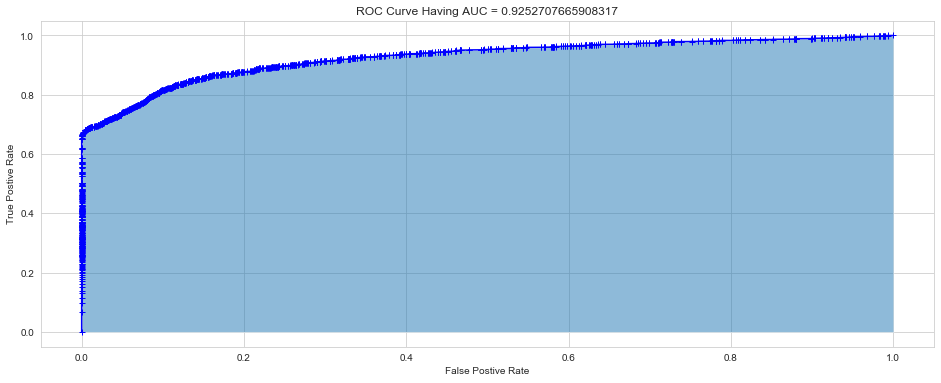

In [100]:
plot_auc_curve(fpr, tpr, auc_test)

# 베이지안 옵티마이저에 대해 알아보자!

- Hyperparameter Optimization이란, 학습을 수행하기 위해 사전에 설정해야 하는 값인 hyperparameter(하이퍼파라미터)의 최적값을 탐색하는 문제를 지칭
-  Manual Search, Grid Search, Random Search, Bayesian optimization, Evolutionary algorithm 

### 그리드 서치
- 모든 parameter의 경우의 수에 대해 cross-validation 결과가 가장 좋은 parameter를 고르는 방법
- 탐색하고자하는 hyperparameter의 개수를 한 번에 여러 종류로 가져갈수록, 전체 탐색 시간이 기하급수적으로 증가한다는 단점

### 베이지안 옵티마이제이션
- Bayesian Optimization은 어느 입력값(x)를 받는 미지의 목적 함수(f(x))를 상정하여, 그 함숫값(f(x))을 최대로 만드는 최적해를 찾는 것을 목적
- 즉, 목적 함수(탐색대상함수)와 해당 하이퍼파라미터 쌍(pair)을 대상으로 Surrogate Model(대체 모델) 을 만들고, 평가를 통해 순차적으로 업데이트해 가면서 최적의 하이퍼파라미터 조합을 탐색